In [67]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from google_drive_downloader import GoogleDriveDownloader as gdd
import seaborn as sb
import sklearn

plt.style.use("dark_background")

## Frappe Dataset
- Frappe 데이터는 2015년 5월에 컨텍스트 인지 모바일 앱 추천시스템을 위해 공개된 현실 데이터인데요,
유저의 앱에 대한 사용 카운트가 96200여개의 로그로 구성되어있는 데이터입니다. 데이터셋 페이퍼

In [214]:
gdd.download_file_from_google_drive(file_id="1bUh06cUbqSi8CxtS5W91vclMCc2q0jxj", dest_path="./frappe.csv")
uses_df = pd.read_csv("frappe.csv")

gdd.download_file_from_google_drive(file_id="1liTfFR_WdF8-ozFh5dyFhWDM0NyF5s7L", dest_path="./frappe_meta.csv")
meta_df = pd.read_csv("frappe_meta.csv", sep="\t")

In [144]:
uses_df.sample(5)

,user,item,daytime,weekday,isweekend,homework,cost,weather,country,city,cnt
43916,136,229,afternoon,sunday,weekend,unknown,free,unknown,unknown,0,7
85772,410,39,sunset,sunday,weekend,unknown,free,cloudy,Spain,369,1
63029,222,319,evening,monday,workday,unknown,free,sunny,Croatia,419,1
70649,271,17,evening,tuesday,workday,unknown,free,unknown,unknown,0,220
21284,66,911,afternoon,tuesday,workday,unknown,free,sunny,United States,0,1


- daytime : 시간대("afternoon", "evening", "morning", "night", "noon", "sunrise", "sunset")
- weekday : 요일
- isweekend : 주중/주말("workday"/"weekend")
- homework : 업무 중/가정("work"/"home"/"unknown")
- cost : 유료/무료("paid"/"free")
- weather : 날씨("cloudy", "drizzle", "foggy", "rainy", "sleet", "snowy", "stormy", "sunny", "unknown")
- country : 국가
- city : 도시(0~1087)
- cnt : 카운트(1~28752)

In [5]:
meta_df.sample(5)

,item,package,category,downloads,developer,icon,language,description,name,price,rating,short desc
1930,1930,com.activision.elite,Entertainment,"1,000,000 - 5,000,000","Activision Publishing, Inc.",http://d2lh3rxs7crswz.cloudfront.net/com.activ...,en,"Access your Call of Duty® HQ anywhere, anytime...",Call of Duty® ELITE,Free,3.5,Play Together Better.
2603,2603,com.innovativegames.knockdown,Arcade & Action,"1,000,000 - 5,000,000",Innovative games,http://d2lh3rxs7crswz.cloudfront.net/com.innov...,en,The game is to knock down the boxes using a sl...,Knock Down,Free,3.8,NaN
2176,2176,com.houzz.app,Lifestyle,"100,000 - 500,000",Houzz,http://d2lh3rxs7crswz.cloudfront.net/com.houzz...,en,"Called the ""Wikipedia of interior and exterior...",Houzz Interior Design Ideas,Free,4.8,NaN
1530,1530,com.bom.android.newsreader.tha,News & Magazines,"10,000 - 50,000",Bestofmedia Group,http://d2lh3rxs7crswz.cloudfront.net/com.bom.a...,en,Tom’s Hardware: The Authority On Tech Get inst...,Tom's Hardware,Free,2.7,Tom’s Hardware: The Authority On TechGet insta...
1048,1048,com.neomtel.mxhome,Productivity,"1,000,000 - 5,000,000","NeoMTel Co.,Ltd.",http://d2lh3rxs7crswz.cloudfront.net/com.neomt...,en,MXHome Launcher (Live Petal Theme) MX Home is ...,MXHome Launcher 3.1,Free,4.4,Art 3D Launcher MXHome


- 추천 목적에 따라서 추천시스템의 알고리즘과 측정 방법 등이 크게 달라집니다. 따라서, 우리는 주어진 데이터로 구성할 추천시스템의 목적을 명확히 할 필요가 있습니다. 이번 Frappe Dataset이라면 다음과 같은 시나리오를 구성해 볼 수 있겠지요.

- 현재 상황에서 특정 어플이 없는 유저(user)에게 어플 추천 광고 집행
- 특정 어플이 있는 유저에게 사용량(cnt)을 더욱 증가시키기 위해 상황에 따른 알림
- 고객에게 상황에 따른 어플 내부 결제 유도 쿠폰 제공
- 특정어플을 고객이 다양한 환경에서 사용하도록 유도하는 최적의 알림 타이밍

- 특정 상황에서 유저가 한번도 사용하지 않았던 어플 중 가장 관심있어 할만한 어플을 찾아주는 문제로 정의할 수 있습니다.

In [4]:
#1번 이상 로그가 있는 Context 에 대해서는 모두 "클릭을 했다" 라는 의미로 `True`로 변경해줍니다.
# uses_df["cnt"] = True

### 요일 및 시간대별 앱 사용량 파악하기

In [49]:
pt = pd.pivot_table(uses_df[["daytime", "weekday", "cnt"]], index="daytime", columns="weekday", values="cnt", aggfunc=np.sum)

col_ord = pt.sum(axis=0).sort_values().index
row_ord = pt.sum(axis=1).sort_values().index

pt = pt.loc[row_ord, col_ord]

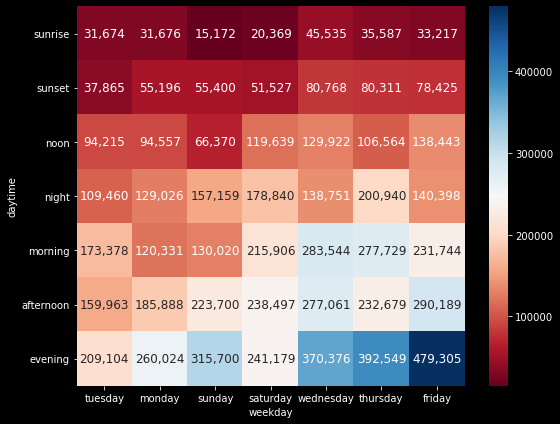

In [50]:
fig, ax = plt.subplots(figsize=(8, 6))

sb.heatmap(ax=ax, data=pt, annot=True, annot_kws={"size": 12}, fmt=",", cmap="RdBu")

fig.tight_layout()

- 화요일 일출 시간에 앱을 가장 적게 사용하고 금요일 저녁 시간대에 가장 많이 사용함을 알 수 있습니다.

### 날씨에 앱 사용량 차이 파악하기

In [47]:
uses_df.loc[uses_df["weather"]=="rainy", :]

,user,item,daytime,weekday,isweekend,homework,cost,weather,country,city,cnt
80,1,5,afternoon,friday,workday,unknown,free,rainy,Spain,0,88
323,1,838,afternoon,friday,workday,unknown,free,rainy,Spain,0,596
420,2,5,evening,thursday,workday,home,free,rainy,Spain,369,8
656,2,78,evening,thursday,workday,home,free,rainy,Spain,369,2
770,3,3,noon,wednesday,workday,unknown,free,rainy,United States,1028,3
...,...,...,...,...,...,...,...,...,...,...,...
93119,822,38,afternoon,wednesday,workday,unknown,paid,rainy,Spain,369,1
93193,844,44,morning,friday,workday,unknown,free,rainy,United Kingdom,401,1
93194,844,58,morning,friday,workday,unknown,free,rainy,United Kingdom,401,1
93198,844,1127,morning,friday,workday,unknown,paid,rainy,United Kingdom,401,1


In [62]:
pt1 = pd.pivot_table(uses_df.loc[uses_df["weather"]=="rainy", ["daytime", "weekday", "cnt"]], index="daytime", columns="weekday", values="cnt", aggfunc=np.sum)

col_ord = pt1.sum(axis=0).sort_values().index
row_ord = pt1.sum(axis=1).sort_values().index

pt1 = pt1.loc[row_ord1, col_ord1]

pt2 = pd.pivot_table(uses_df.loc[uses_df["weather"]=="sunny", ["daytime", "weekday", "cnt"]], index="daytime", columns="weekday", values="cnt", aggfunc=np.sum)

pt2 = pt2.loc[row_ord, col_ord]

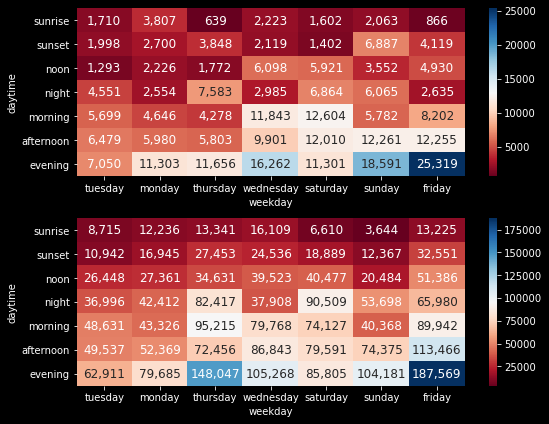

In [65]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 6))

sb.heatmap(ax=ax1, data=pt1, annot=True, annot_kws={"size": 12}, fmt=",", cmap="RdBu")
sb.heatmap(ax=ax2, data=pt2, annot=True, annot_kws={"size": 12}, fmt=",", cmap="RdBu")

fig.tight_layout()

## DeepFM
### 특징 1
- 각 피쳐의 임베딩을 FM모델과 DeepLearning 모델이 공유하고 있다.
- 피쳐 엔지니어링에 들어가는 수고를 많이 덜어낼 수 있습니다.

### 특징 2
- 미리 학습(Pre-trained)하지 않고 한번의 Input으로 End-to-end로 진행한다.
- 다른 모델의 경우 FM으로 미리 한번 학습된 Embedding으로 Deeplearning모델을 학습하는 경우가 있습니다. 한번에 모델을 학습시킬 수 있으므로, 학습의 어려움이 적습니다.
### deepFM 모델 구성하기
#### (1) input layer 구성하기
- 모델의 입력 변수로는 아래의 피쳐들이 필요합니다.
$$
x_{user},\ x_{item},\ x_{daytime},\ x_{weekday},\ x_{isweekend},\ x_{homework},\ x_{cost},\ x_{weather},\ x_{country},\ x_{city}
$$

In [215]:
uses_df.sample(5)

,user,item,daytime,weekday,isweekend,homework,cost,weather,country,city,cnt
56243,186,48,noon,thursday,workday,unknown,free,cloudy,Spain,369,42
89537,506,73,evening,saturday,weekend,unknown,free,rainy,Indonesia,0,7
75713,300,181,sunset,sunday,weekend,unknown,free,unknown,unknown,0,1
68004,254,797,morning,sunday,weekend,unknown,free,sunny,United States,0,149
38569,117,181,afternoon,wednesday,workday,unknown,free,cloudy,Chile,151,1


- frappe dataset는 전부 categorical vatiables로 구성되어 있으므로 입력값의 형태는 0-d, 즉 Index로만 존재하게 됩니다.

In [216]:
for col in uses_df.columns:    
    print(f"{col} | {uses_df[col].shape}")

user | (93308,)
item | (93308,)
daytime | (93308,)
weekday | (93308,)
isweekend | (93308,)
homework | (93308,)
cost | (93308,)
weather | (93308,)
country | (93308,)
city | (93308,)
cnt | (93308,)


- 위의 구성에서 93308은 데이터의 갯수를 의미하는 축이고, 데이터의 Shape은 이후 숫자가 데이터의 Shape이 됩니다. 현재 각 데이터의 Shape은 0차원입니다. 이러한 데이터를 입력받기 위해서는 차원이 ()인 Input레이어를 만들어 주어야 합니다.

In [217]:
#input layer를 구성합니다.
inputs = {}
for col in uses_df.columns:
    if col != "cnt":
        inputs[col] = tf.keras.Input(shape=(), name="a")

In [218]:
inputs

{'user': <tf.Tensor 'a_10:0' shape=(None,) dtype=float32>,
 'item': <tf.Tensor 'a_11:0' shape=(None,) dtype=float32>,
 'daytime': <tf.Tensor 'a_12:0' shape=(None,) dtype=float32>,
 'weekday': <tf.Tensor 'a_13:0' shape=(None,) dtype=float32>,
 'isweekend': <tf.Tensor 'a_14:0' shape=(None,) dtype=float32>,
 'homework': <tf.Tensor 'a_15:0' shape=(None,) dtype=float32>,
 'cost': <tf.Tensor 'a_16:0' shape=(None,) dtype=float32>,
 'weather': <tf.Tensor 'a_17:0' shape=(None,) dtype=float32>,
 'country': <tf.Tensor 'a_18:0' shape=(None,) dtype=float32>,
 'city': <tf.Tensor 'a_19:0' shape=(None,) dtype=float32>}

###  선형회귀 부분 구성하기(order-1)
$$
logits_{lr} = W_{user}X_{user} + W_{item}X_{item} + ⋯ + W_{city}X_{city} + b
$$

- features가 categorical variables이므로 예를 들어 user : 927, item : 14, daytime : morning, ... 인 경우 다음 식으로 간단히 표현됩니다.
$$
logits_{lr} = w_{user\ :\ 927} + w_{item\ :
 14} + w_{city\ :\ morning} + ⋯ + b
$$

In [31]:
uses_df

,user,item,daytime,weekday,isweekend,homework,cost,weather,country,city,cnt
0,0,0,morning,sunday,weekend,unknown,free,sunny,United States,0,1
1,0,9,afternoon,friday,workday,unknown,free,cloudy,United States,1023,2
2,0,9,evening,friday,weekend,unknown,free,cloudy,United States,1023,9
3,0,14,afternoon,friday,workday,unknown,free,cloudy,United States,1023,2
4,0,16,evening,friday,weekend,unknown,free,cloudy,United States,1023,1
...,...,...,...,...,...,...,...,...,...,...,...
93303,927,526,morning,friday,workday,unknown,free,unknown,unknown,0,1
93304,936,11,night,tuesday,workday,unknown,free,cloudy,Malaysia,746,1
93305,936,57,night,friday,workday,unknown,free,cloudy,Malaysia,746,13
93306,936,126,night,tuesday,workday,unknown,free,cloudy,Malaysia,746,3


In [6]:
#embedding layer를 구성합니다.
lr_embs = []
for col in uses_df.columns:
    if col != "cnt":
        lr_embs.append(tf.keras.layers.Embedding(input_dim= uses_df[col].nunique(), output_dim=1, name=f"{col}_lr_emb")(inputs[col]))

In [15]:
lr_embs

[<tf.Tensor 'user_lr_emb/Identity:0' shape=(None, 1) dtype=float32>,
 <tf.Tensor 'item_lr_emb/Identity:0' shape=(None, 1) dtype=float32>,
 <tf.Tensor 'daytime_lr_emb/Identity:0' shape=(None, 1) dtype=float32>,
 <tf.Tensor 'weekday_lr_emb/Identity:0' shape=(None, 1) dtype=float32>,
 <tf.Tensor 'isweekend_lr_emb/Identity:0' shape=(None, 1) dtype=float32>,
 <tf.Tensor 'homework_lr_emb/Identity:0' shape=(None, 1) dtype=float32>,
 <tf.Tensor 'cost_lr_emb/Identity:0' shape=(None, 1) dtype=float32>,
 <tf.Tensor 'weather_lr_emb/Identity:0' shape=(None, 1) dtype=float32>,
 <tf.Tensor 'country_lr_emb/Identity:0' shape=(None, 1) dtype=float32>,
 <tf.Tensor 'city_lr_emb/Identity:0' shape=(None, 1) dtype=float32>]

In [41]:
class LR(tf.keras.layers.Layer):
    def build(self, input_shape):
        # 레이어 연결시 0으로 초기화된 학습 가중치 생성
        self.b = self.add_weight(shape=(1, ), initializer="zeros", trainable=True)
        super().build(input_shape)
    
    def call(self, inputs, **kwargs):
        logits = tf.add_n(inputs) + self.b
        return logits

In [42]:
logits_lr = LR(name="lr")(lr_embs)

In [43]:
logits_lr

<tf.Tensor 'lr_1/Identity:0' shape=(None, 1) dtype=float32>

### (2) Factorization 부분 구성하기(Order-2)

In [8]:
fm_size = 5

fm_embs = []
for col in uses_df.columns:
    if col != "cnt":
#         fm_embs.append(tf.keras.layers.Embedding(input_dim= uses_df[col].nunique(), output_dim=fm_size, name=f"{col}_fm_emb")(inputs[col]))
        print(tf.keras.layers.Embedding(input_dim= uses_df[col].nunique(), output_dim=fm_size, name=f"{col}_fm_emb").get_weights)

<bound method Layer.get_weights of <tensorflow.python.keras.layers.embeddings.Embedding object at 0x000001CA2497ECC8>>
<bound method Layer.get_weights of <tensorflow.python.keras.layers.embeddings.Embedding object at 0x000001CA24970F48>>
<bound method Layer.get_weights of <tensorflow.python.keras.layers.embeddings.Embedding object at 0x000001CA248A3F48>>
<bound method Layer.get_weights of <tensorflow.python.keras.layers.embeddings.Embedding object at 0x000001CA24970F48>>
<bound method Layer.get_weights of <tensorflow.python.keras.layers.embeddings.Embedding object at 0x000001CA24970F48>>
<bound method Layer.get_weights of <tensorflow.python.keras.layers.embeddings.Embedding object at 0x000001CA2488E048>>
<bound method Layer.get_weights of <tensorflow.python.keras.layers.embeddings.Embedding object at 0x000001CA24970F48>>
<bound method Layer.get_weights of <tensorflow.python.keras.layers.embeddings.Embedding object at 0x000001CA2488E048>>
<bound method Layer.get_weights of <tensorflow.p

In [12]:
tf.keras.layers.Embedding(input_dim= uses_df[col].nunique(), output_dim=fm_size, name=f"{col}_fm_emb")

In [11]:
fm_embs[0]

IndexError: list index out of range

### 3. 데이터 구성하기
#### (1) 명목형 데이터의 인덱싱 표 만들기
- 명목형 데이터에서 각 값을 임베딩 행렬에서 몇 번째 벡터를 가르키는지를 지칭하는 임베딩 인덱스로 바꾸어 주기 위해서, 인덱싱 표를 생성합니다.

In [145]:
cat2idx = {}
cat2size = {}
for col in uses_df.columns:
    if col != "cnt":
        uses_df[col] = uses_df[col].astype("category")
        
        cat2idx[col] = {cat:idx for idx, cat in enumerate(uses_df[col].cat.categories)}
        cat2size[col] = len(uses_df[col].cat.categories)

In [146]:
print(cat2idx)

{'user': {0: 0, 1: 1, 2: 2, 3: 3, 4: 4, 5: 5, 6: 6, 7: 7, 8: 8, 9: 9, 10: 10, 11: 11, 12: 12, 13: 13, 14: 14, 15: 15, 16: 16, 17: 17, 18: 18, 19: 19, 20: 20, 21: 21, 22: 22, 23: 23, 24: 24, 25: 25, 26: 26, 27: 27, 28: 28, 29: 29, 30: 30, 31: 31, 32: 32, 33: 33, 34: 34, 35: 35, 36: 36, 37: 37, 38: 38, 39: 39, 40: 40, 41: 41, 42: 42, 43: 43, 44: 44, 45: 45, 46: 46, 47: 47, 48: 48, 49: 49, 50: 50, 51: 51, 52: 52, 53: 53, 54: 54, 55: 55, 56: 56, 57: 57, 59: 58, 60: 59, 61: 60, 62: 61, 63: 62, 64: 63, 65: 64, 66: 65, 67: 66, 68: 67, 69: 68, 70: 69, 71: 70, 72: 71, 73: 72, 74: 73, 75: 74, 76: 75, 77: 76, 78: 77, 79: 78, 80: 79, 81: 80, 82: 81, 83: 82, 84: 83, 85: 84, 86: 85, 87: 86, 88: 87, 89: 88, 90: 89, 91: 90, 92: 91, 93: 92, 94: 93, 95: 94, 96: 95, 97: 96, 98: 97, 99: 98, 100: 99, 101: 100, 102: 101, 103: 102, 104: 103, 105: 104, 106: 105, 107: 106, 108: 107, 109: 108, 110: 109, 111: 110, 112: 111, 113: 112, 114: 113, 115: 114, 116: 115, 117: 116, 118: 117, 119: 118, 120: 119, 121: 120,

In [147]:
cat2size

{'user': 792,
 'item': 2072,
 'daytime': 7,
 'weekday': 7,
 'isweekend': 2,
 'homework': 3,
 'cost': 2,
 'weather': 9,
 'country': 78,
 'city': 223}

#### (2) 각 column의 값을 embedding matrix의 index로 변경하기

In [148]:
for col, dic in cat2idx.items():
    uses_df[col] = uses_df[col].map(dic)

#### (3) train set과 test set으로 구분하기

In [171]:
train, test = sklearn.model_selection.train_test_split(uses_df, train_size=0.8)

#### (4) 네거티브샘플링 적용하기
현재 해당 데이터는 특정 컨택스트에서 고객의 앱에 대한 사용 여부로서 "Positive" 데이터만 존재하고 있습니다. 즉, 고객 행동의 긍정적인 행동만 기록되어있다는 것입니다. 우리는 고객이 클릭하지 않은 앱에 대한 사용 여부, 즉 Positive 데이터 한개당 Negative 데이터 3개씩을 생성하되 item 이외의 다른 feature는 고정하고 item을 무작위로 결정하는 식으로 진행해보도록 하겠습니다.

In [184]:
def do_neg_sampling(df, ratio=3):
    neg_sampling = pd.concat([df]*ratio)
    neg_sampling["item"] = df["item"].sample(n=len(neg_sampling), replace=True).values
    # "네거티브 데이터"는 카운트가 존재하지 않음
    neg_sampling["cnt"] = 0

    sampling = pd.concat([df, neg_sampling])
    sampling = sampling.drop_duplicates(sampling.columns.drop("cnt"))
    return sampling

In [185]:
train_sampling = do_neg_sampling(train)
test_sampling = do_neg_sampling(test)

- (3) Input 과 Target 분리
- 데이터 중에서 종속 변수가 되는 요소들( X )과 독립 변수가 되는 클릭 유무을 나누도록 하겠습니다.

In [187]:
train_x = train.drop(["cnt"], axis=1)
train_y = train[["cnt"]]

test_x = test.drop(["cnt"], axis=1)
test_y = test[["cnt"]]

- (4) 텐서로 바꾸어 주기

In [207]:
batch_size = 512

train_set = tf.data.Dataset.from_tensor_slices(({k:v.values.astype("int16") for k, v in train_x.iteritems()}, train_y.values)).shuffle(len(train_x)).batch(batch_size, drop_remainder=True)
test_set = tf.data.Dataset.from_tensor_slices(({k:v.values.astype("int16") for k, v in test_x.iteritems()}, test_y.values)).shuffle(len(test_x)).batch(batch_size, drop_remainder=True)

In [208]:
train_set

<BatchDataset shapes: ({user: (512,), item: (512,), daytime: (512,), weekday: (512,), isweekend: (512,), homework: (512,), cost: (512,), weather: (512,), country: (512,), city: (512,)}, (512, 1)), types: ({user: tf.int16, item: tf.int16, daytime: tf.int16, weekday: tf.int16, isweekend: tf.int16, homework: tf.int16, cost: tf.int16, weather: tf.int16, country: tf.int16, city: tf.int16}, tf.int64)>

In [211]:
train_x

,user,item,daytime,weekday,isweekend,homework,cost,weather,country,city
38883,119,56,3,3,0,1,0,8,75,0
35512,104,19,1,4,1,1,0,0,75,181
80882,355,506,0,3,0,1,0,7,55,148
20930,64,190,1,0,0,0,0,0,17,0
93222,770,283,2,5,1,1,0,7,75,0
...,...,...,...,...,...,...,...,...,...,...
31665,90,23,3,2,0,1,0,3,12,0
89659,501,462,0,2,0,1,0,0,75,173
15745,48,36,2,1,1,1,1,7,67,0
43259,133,100,4,1,1,2,0,0,75,0
